View the full project at: 
https://www.kaggle.com/code/natecekay/dog-breed-image-classification

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
# Setting random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

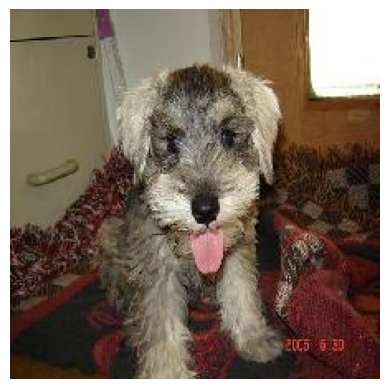

In [3]:
sample_image_path = os.path.join('/kaggle/input/dog-breed-image-classification-dataset/data', 'Bedlington_terrier', 'Bedlington_terrier_1.jpg')

image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.axis('off')
plt.show()

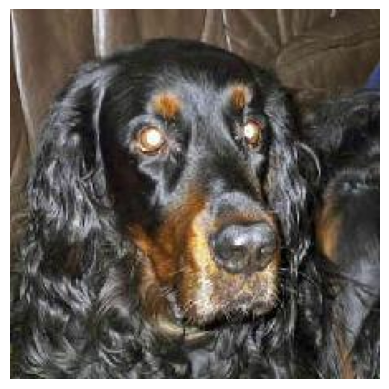

In [4]:
sample_image_path = os.path.join('/kaggle/input/dog-breed-image-classification-dataset/data', 'Gordon_setter', 'Gordon_setter_11.jpg')

image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.axis('off')
plt.show()

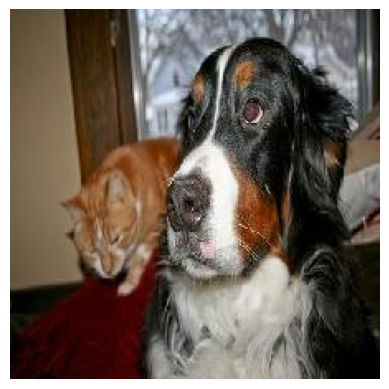

In [5]:
sample_image_path = os.path.join('/kaggle/input/dog-breed-image-classification-dataset/data', 'Bernese_mountain_dog', 'Bernese_mountain_dog_1.jpg')

image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
device = torch.device("cpu")
print(f"Running on device: {device}")

Running on device: cpu


In [7]:
# Defining the data directory and transformations
data_dir = "/kaggle/input/dog-breed-image-classification-dataset/data"

In [8]:
img_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
dataset = datasets.ImageFolder(root=data_dir, transform=img_transforms)
num_classes = len(dataset.classes)

In [10]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

In [11]:
batch_size = 32
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [12]:
# initializing ResNet50 model and modifying the final layer for classification

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Defining loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [14]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # evaluate on test set
        accuracy = evaluate_model(model, test_loader, print_results=False)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Saved best model with accuracy: {best_accuracy:.2f}%")

In [15]:
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, print_results=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if print_results:
        print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [16]:
# Function to visualize the model's predictions
def visualize_results(loader, model):
    class_names = dataset.classes
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        fig = plt.figure(figsize=(15, 10))
        for idx in range(8):  # Show 8 images
            ax = fig.add_subplot(2, 4, idx + 1)
            ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
            pred_class = class_names[preds[idx]]
            actual_class = class_names[labels[idx]]
            confidence = probabilities[idx][preds[idx]].item() * 100
            ax.title.set_text(f"Predicted: {pred_class}\nActual: {actual_class}\nConfidence: {confidence:.2f}%")
            ax.axis("off")
        plt.show()

In [17]:
num_epochs = 10
print("Training the model...")
train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs)

Training the model...
Epoch [1/10], Loss: 0.6361
Saved best model with accuracy: 72.19%
Epoch [2/10], Loss: 0.4976
Saved best model with accuracy: 84.11%
Epoch [3/10], Loss: 0.3582
Saved best model with accuracy: 87.42%
Epoch [4/10], Loss: 0.2213
Saved best model with accuracy: 92.05%
Epoch [5/10], Loss: 0.2071
Epoch [6/10], Loss: 0.2099
Saved best model with accuracy: 94.04%
Epoch [7/10], Loss: 0.0456
Saved best model with accuracy: 94.70%
Epoch [8/10], Loss: 0.0513
Saved best model with accuracy: 96.69%
Epoch [9/10], Loss: 0.0573
Epoch [10/10], Loss: 0.0502


In [18]:
print("Evaluating the model...")
evaluate_model(model, test_loader)

Evaluating the model...
Test Accuracy: 96.69%


96.6887417218543

Visualizing results...


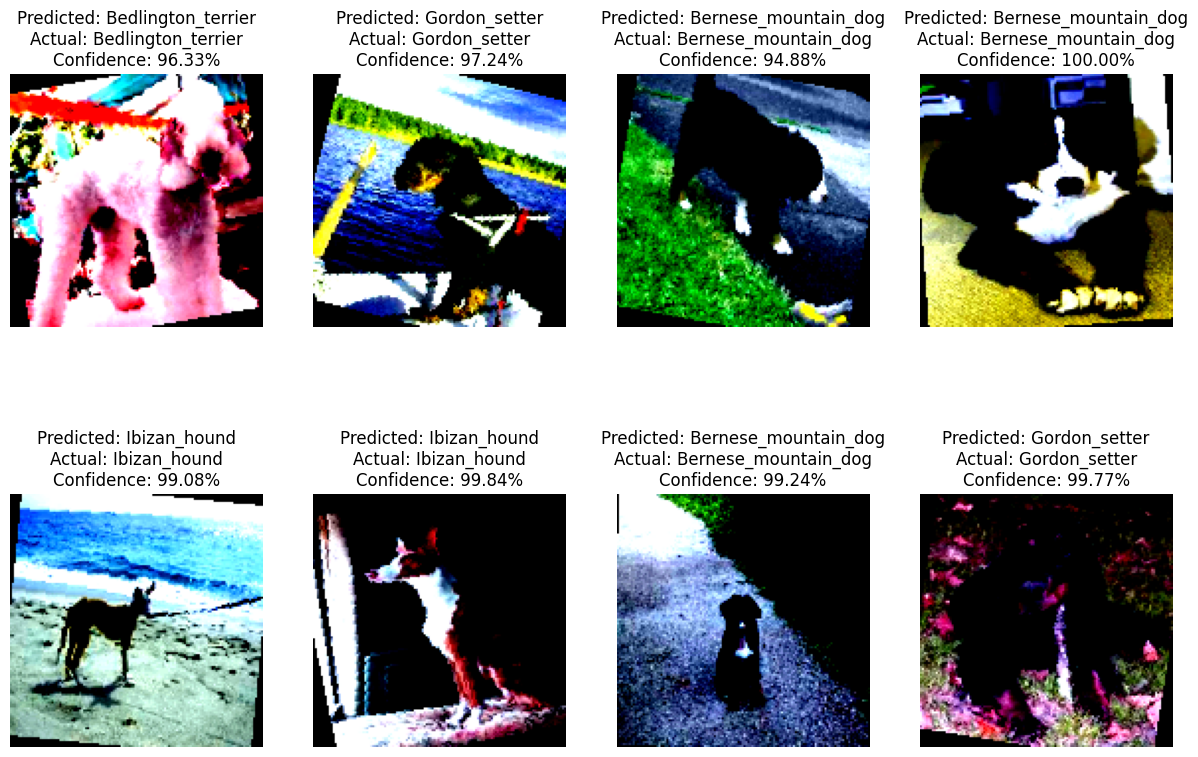

In [19]:
print("Visualizing results...")
visualize_results(test_loader, model)

The final model achieved an impressive accuracy of test accuracy of 96.69%. This model can be used on different types of images, and is ideal for image classification tasks.  